In [1007]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import gsw
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import viz_tools, utilities, places
from itertools import repeat, groupby
from scipy.signal import butter, lfilter, argrelextrema

%matplotlib inline

In [1428]:
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc').isel(t=0)
paths = {
    'loadpath': '/results/SalishSea/hindcast.201812',
    'loadpath_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'savepath': '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast',
    'date_cutoff': '2016 Nov 21',
}

In [119]:
def make_prefix(date, paths, res='h'):
    """
    """
    
    datestr = date.strftime('%Y%m%d')
    path = paths['loadpath']
    if paths['date_cutoff'] is not None:
        if date >= parse(paths['date_cutoff']):
            path = paths['loadpath_cutoff']
    fn = '_'.join(['SalishSea', f'1{res}', *repeat(datestr, 2), ''])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

## Isolating upwelling metrics from density cross-sections

In [1475]:
# Upwelling event date windows
events = [[parse(date) for date in window] for window in [
    ['2015 Mar 11', '2015 Mar 14'],
]]
events2 = [[
    ['2015 Mar 18', '2015 Mar 22'],
    ['2015 Mar 24', '2015 Mar 29'],
    ['2015 Mar 28', '2015 Apr 01'],
    ['2015 Apr 25', '2015 Apr 30'],
    #['2015 Aug 27', '2015 Sep 01'],
    #['2015 Oct 06', '2015 Oct 13'],
    ['2016 Apr 11', '2016 Apr 15'],
    ['2017 Apr 03', '2017 Apr 12'],
    ['2017 May 30', '2017 Jun 04'],
    ['2017 Sep 09', '2017 Sep 13'],
    ['2017 Sep 17', '2017 Sep 20'],
    #['2017 Oct 14', '2017 Oct 21'],
    ['2017 Oct 21', '2017 Oct 25'],
    ['2018 Mar 21', '2018 Mar 25'],
    ['2018 Apr 03', '2018 Apr 13'],
    ['2018 Apr 13', '2018 Apr 16'],
    ['2018 Sep 07', '2018 Sep 13'],
    ['2018 Sep 14', '2018 Sep 18'],
    ['2018 Oct 23', '2018 Nov 03'],
    
]]

Loading ... N/A% (0 of 1) |                                               |ETA:  --:--:--/home/bmoorema/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
Loading ... 100% (1 of 1) |################################################|Time: 0:00:31


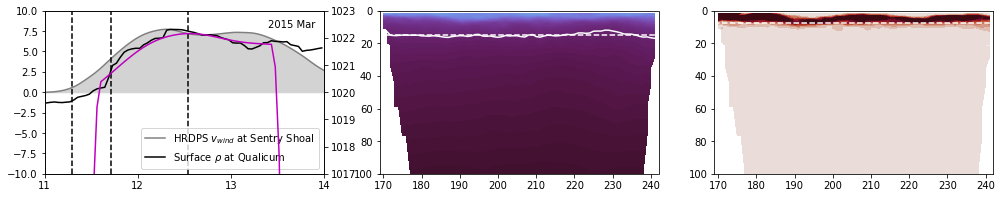

In [1480]:
timerange = [datetime(2015, 3, 10), datetime(2015, 4, 1)]
xlim = [169, 242]
loc = (547, slice(*xlim))
keys = ['vosaline', 'votemper']
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
Q = {}
n_events = len(events)
w = np.hanning(30)
w = w / w.sum()
deptht = mask.gdept_1d.values

# Make figure
fig = plt.figure(figsize=(17, 3 * n_events))
gs = plt.GridSpec(n_events, 3)
#cax = fig.add_axes([0.2, 0.1, 0.6, 0.04/n_events])

# Loop through events
bar = utilities.statusbar('Loading ...')
for row, event in zip(bar(range(n_events)), events):

    # Event name
    tag = event[0].strftime('%Y%m%d')
    Q[tag] = {}
    
    # Generate rho timeseries
    time = np.empty(0, dtype='datetime64')
    rho = np.empty(0)
    for day in range(np.diff(event)[0].days):
        prefix = make_prefix(event[0] + timedelta(days=day), paths)
        with xr.open_dataset(prefix + 'grid_T.nc').isel(deptht=0, y=loc[0], x=loc[1]) as data:
            time = np.concatenate((time, data.time_counter.values))
            rho = np.concatenate((rho, gsw.rho(*[data[k].values.max(axis=1) for k in keys], 0)))
    
    # Extract and filter wind record
    v_time = HRDPS.time.sel(time=slice(*event)).values
    v_wind = HRDPS.v_wind.sel(time=slice(*event))[:, j, i].values
    fs = 1 / 3600
    cutoff = 1 / 86400 * 0.5
    v_filt = lfilter(*butter(2, cutoff / fs / 0.5, btype='lowpass'), v_wind)
    
    # Plot wind and surface density
    ax = fig.add_subplot(gs[row, 0])
    ax.set_xlim(event)
    ax.set_ylim([-10, 10])
    ax.fill_between(v_time, v_filt, color='lightgray')
    l1 = ax.plot(v_time, v_filt, color='gray', label='HRDPS $v_{wind}$ at Sentry Shoal')
    ax2 = ax.twinx()
    l2 = ax2.plot(time, rho, color='k', label='Surface $\\rho$ at Qualicum')
    ax2.set_ylim([1017, 1023])
    ax.text(0.8, 0.9, event[0].strftime('%Y %b'), transform=ax.transAxes)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    if row == n_events - 1:
        lns = l1 + l2
        ax.legend(lns, [l.get_label() for l in lns], loc=4)
    
    # Find onset defined by continous v_wind (18 hours)
    k = 0
    for a, b, in groupby(v_filt > 0.5):
        count = sum(1 for i in b)
        if a and (count > 18): Q[tag]['onset'] = k; break
        k = k + count
    
    # Find upwelling peak defined by rho_max
    rho_smooth = np.convolve(w, rho, mode='same')    
    extrema = argrelextrema(rho_smooth, np.greater)[0]
    Q[tag]['peak'] = int(extrema[extrema > Q[tag]['onset']][0])
    
    # Plot onset and peak rho
    ax2.plot(time, rho_smooth, 'm-')
    
    # Find remaining metrics
    Q[tag]['rho_0'] = max(rho[slice(max(Q[tag]['onset'] - 12, 0), Q[tag]['onset'] + 12)])
    Q[tag]['rho_max'] = max(rho)

    # Construct density cross-section
    date = event[0] + timedelta(hours=Q[tag]['onset'])
    prefix = make_prefix(date, paths)
    data = xr.open_dataset(prefix + 'grid_T.nc').sel(time_counter=date, method='nearest')
    deptht_expanded = np.expand_dims(deptht, axis=1)
    rho_0 = gsw.rho(*[np.ma.masked_where(
        mask.tmask[(slice(None),) + loc] == 0, data[k][(slice(None),) + loc]
    ) for k in keys], deptht_expanded)
    N2 = 9.81 * np.diff(rho_0, axis=0) / (1024 * deptht_expanded[1:])
    Q[tag]['N2_max'] = np.median(N2.max(axis=0).compressed())
    Q[tag]['N2_depth'] = np.max([deptht[i + 1] for i in N2.argmax(axis=0)])
    Q[tag]['rho_C'] = np.ma.max([rho_0[i, j] for j, i in enumerate(N2.argmax(axis=0))])
    Q[tag]['upwell'] = int((rho > Q[tag]['rho_C']).argmax())
    Q[tag]['tau_max'] = 1.225e-3 * v_filt[Q[tag]['upwell']]**2
    
    for hour in ['onset', 'upwell', 'peak']:
        timestamp = HRDPS.time.sel(time=event[0] + timedelta(hours=Q[tag][hour])).values
        ax.plot([timestamp, timestamp], [-10, 10], 'k--')

    # Loop through N2 and rho
    levellist = [[1016, 1024, 0.1], [1e-5, 1e-3, 1e-4]]
    for col, var, cmap, levels in zip(range(1, 3), [rho_0[1:, :], N2], ['dense', 'amp'], levellist):
        
        # Make axes and plot formatting
        ax = fig.add_subplot(gs[row, col])
        ax.set_xlim(xlim)
        ax.set_ylim([100, 0])
        
        if col == 1:
            
            # Create contour of rho_max
            c = ax.contour(data.x[loc[1]], deptht, rho_0, levels=[Q[tag]['rho_max']])
            c_max = []
            for contour in c.collections[0].get_paths():
                if len(contour) > len(c_max): c_max = contour.vertices
            c.collections[0].remove()

            # Plot contours
            ax.plot(c_max[:, 0], c_max[:, 1], 'w-', label='$\\rho_{max}$')
            Q[tag]['rho_depth'] = c_max[:, 1].mean()
            ax.plot(xlim, [Q[tag]['rho_depth'], Q[tag]['rho_depth']], 'w--', label='$\\rho_{max}$ (mean)')
            
        else:
            ax.plot(xlim, [Q[tag]['N2_depth'], Q[tag]['N2_depth']], 'w--', label='$N2_{max}$ (mean)')

        # Plot contours
        c = ax.contourf(
            data.x[loc[1]], deptht[1:], var, levels=np.arange(*levels), cmap=getattr(cm, cmap), extend='both', zorder=0,
        )

        # Plot legend and suppress tick labels
        if row < n_events - 1:
            ax.xaxis.set_ticklabels('')
        else:
            if hour is 'onset': ax.legend(loc=4)
            
#fig.colorbar(c, cax=cax, orientation='horizontal', label='$\\rho$ [kg/m$^3$]')
plt.show()

In [1484]:
tag = '20150311'
T = (Q[tag]['upwell'] - Q[tag]['onset']) * 3600
tau_calc = Q[tag]['rho_0'] * np.sqrt(Q[tag]['N2_max']) * Q[tag]['N2_depth']**2 / (2 * T)
print(np.sqrt(Q[tag]['tau_max']/1.225e-3), np.sqrt(tau_calc/1.225e-3))

4.076384838876477 4.924698369378455


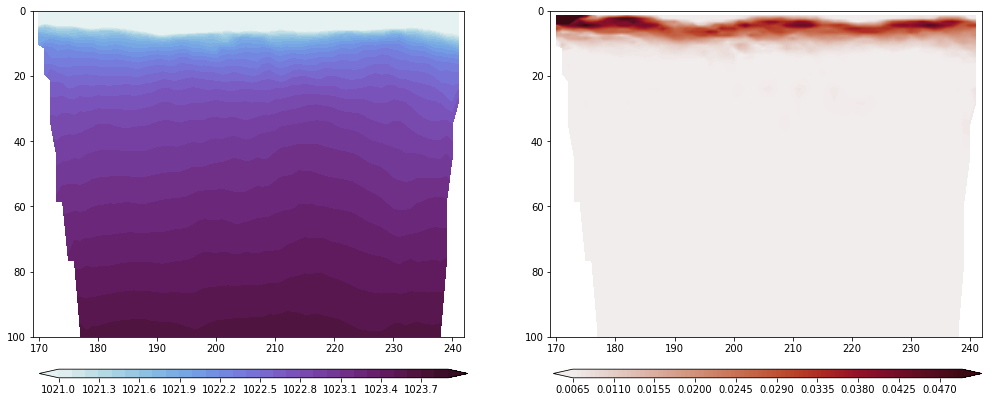

In [1330]:
N = np.sqrt(9.81 * np.diff(rho_0, axis=0) / (1024 * np.expand_dims(data.deptht, 1)[1:]))

fig, axs = plt.subplots(1, 2, figsize=(17, 6))
for ax, var, levels, cmap, idepth, x in zip(
    axs, [rho_0, N], [[1021, 1024, 0.1], [6.5e-3, 5e-2, 5e-4]], [cm.dense, cm.amp], [0, 1], [0.13, 0.55]
):

    cax = fig.add_axes([x, 0.03, 0.35, 0.02])
    c = ax.contourf(data.x, data.deptht[idepth:], var, levels=np.arange(*levels), cmap=cmap, extend='both')
    ax.set_xlim([169, 242])
    ax.set_ylim([100, 0])
    fig.colorbar(c, cax=cax, orientation='horizontal')

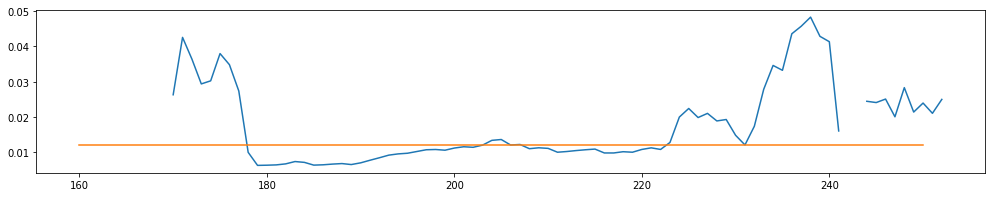

In [1251]:
Nmax = N.max(axis=0)
Nmedian = np.median(N.max(axis=0).compressed())

fig, ax = plt.subplots(1, 1, figsize=(17, 3))
ax.plot(Nmax)
ax.plot([160, 250], [Nmedian, Nmedian])

Loading ... 100% (1 of 1) |################################################|Time: 0:00:00


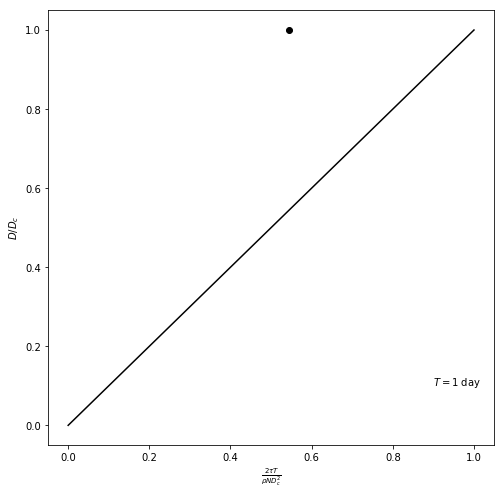

In [1470]:
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k')
ax.set_xlabel('$\\frac{2\\tau T}{\\rho N D_c^2}$')
ax.set_ylabel('$D/D_c$')
ax.text(0.9, 0.1, '$T = 1$ day')
bar = utilities.statusbar('Loading ...')
for n, event in enumerate(bar(events)):
    tag = event[0].strftime('%Y%m%d')
    T = (Q[tag]['upwell'] - Q[tag]['onset']) * 3600
    D_calc = 2 * T * Q[tag]['tau_max'] / (Q[tag]['rho_0'] * np.sqrt(Q[tag]['N2_max']) * Q[tag]['N2_depth']**2)
    
    #D_calc = np.sqrt(400 / (9.81 * Q[tag]['rho_max'] * (Q[tag]['rho_max'] - Q[tag]['rho_0']) * Q[tag]['N2_depth'] * (400 - Q[tag]['N2_depth'])))
    #D_calc = D_calc * 2 * T * Q[tag]['tau_max'] / Q[tag]['N2_depth']
    
    
    D_model = Q[tag]['rho_depth'] / Q[tag]['N2_depth']
    #date = event[0] + timedelta(hours=metrics[eventname]['hour_onset'])
    #U = HRDPS.v_wind.sel(time=slice(date, date + timedelta(hours=48)))[:, j, i].values.mean()
    ax.plot(D_calc, 1, 'ko')

## Scaling arguments

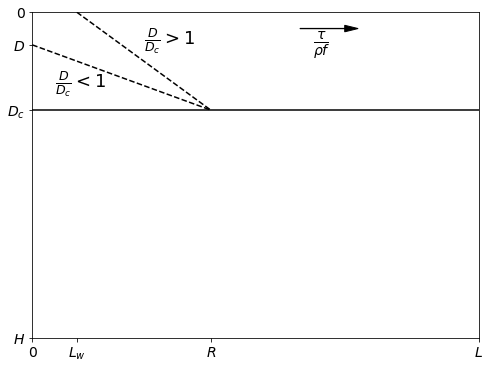

In [689]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax.plot([0, 1], [0.7, 0.7], 'k-')
ax.plot([0, 0.4], [0.9, 0.7], 'k--')
ax.plot([0.1, 0.4], [1, 0.7], 'k--')

ax.xaxis.set_ticks([0, 0.1, 0.4, 1])
ax.xaxis.set_ticklabels([0, '$L_w$', '$R$', '$L$'])
ax.yaxis.set_ticks([0, 0.7, 0.9, 1])
ax.yaxis.set_ticklabels(['$H$', '$D_c$', '$D$', 0])

ax.arrow(0.6, 0.95, 0.1, 0, head_width=0.02, color='k')
ax.text(0.63, 0.89, '$\\frac{\\tau}{\\rho f}$', size=20)
ax.text(0.05, 0.77, '$\\frac{D}{D_c} < 1$', size=18)
ax.text(0.25, 0.9, '$\\frac{D}{D_c} > 1$', size=18)

plt.show()

### Depth of upwelling

Conservation of mass (Ekman flux over time equals pycnocline displacement)

$$\frac{DR}{2} = \frac{\tau T}{\rho f}$$

where

$$R = \frac{ND_c}{f}$$

Thus

$$\frac{D}{D_c} = \frac{2\tau T}{\rho ND_c^2}$$

Incidentally, Csanady (1982) gives evolving wind setup as

$$\xi = \frac{u_*^2t}{c}e^{x/R}$$

which simplifies to the same relation along the coast.

### Upwelling flux

When $D/D_c = 1$

$$\frac{D_c\left(R + L_w\right)}{2} = \frac{\tau T}{\rho f}$$

Considering again R

$$\frac{L_w}{R} = \frac{2\tau T}{\rho ND_c^2} - 1$$

(1021, 1023)

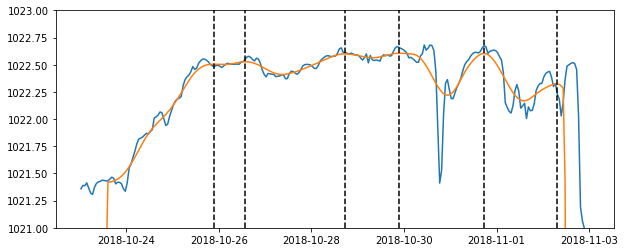

In [1020]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(time, rho)

w = np.hanning(30)
rho_smooth = np.convolve(w / w.sum(), rho, mode='same')
ax.plot(time, rho_smooth)

for t in time[argrelextrema(rho_smooth, np.greater)]:
    ax.plot([t, t], [1021, 1023], 'k--')



#hour_peak = int((rho > (1 - 2e-4) * max(rho)).argmax())
#ax.plot([time[onset], time[onset]], [1020, 1023])
#ax.set_xlim([v_time[0], v_time[-1]])
ax.set_ylim([1021, 1023])

In [1023]:
np.hanning(30) / np.hanning(30).sum()

array([0.        , 0.00080619, 0.00318705, 0.00703127, 0.01215909,
       0.01833074, 0.02525764, 0.0326159 , 0.04006145, 0.04724614,
       0.05383404, 0.05951709, 0.06402956, 0.06716045, 0.06876338,
       0.06876338, 0.06716045, 0.06402956, 0.05951709, 0.05383404,
       0.04724614, 0.04006145, 0.0326159 , 0.02525764, 0.01833074,
       0.01215909, 0.00703127, 0.00318705, 0.00080619, 0.        ])

In [1032]:
extrema = argrelextrema(rho_smooth, np.greater)[0]
extrema[extrema > 80][0]

85

In [1037]:
type(extrema[extrema > Q[tag]['onset']][0])

numpy.int64

In [1085]:
np.sqrt(9.81 * 10 * 20 * 300 / 320 / 1.25e3) / 1e-4 / 1e3

12.13053997149344

In [1086]:
np.sqrt(9.81 * 10 / 1025 / 20)

0.06917633882808873